In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Introduction
2. Load and check data
* 2.1 load data
* 2.2 Outlier detection
* 2.3 joining train and test set
* 2.4 check for null and missing values
3. Feature analysis
* 3.1 Numerical values
* 3.2 Categorical values
4. Filling missing values
* 4.1 Age
5. Feature Engineering
* 5.1 Name/Title
* 5.2 Family Size
* 5.3 Cabin
* 5.4 Ticket
6. Modeling
* 6.1 Simple modeling
  * 6.1.1 Cross validate models
  * 6.1.2 Hyperparameter tunning for best models
  * 6.1.3 Plots learning curves
  * 6.1.4 Feature importances of the tree based classifiers
* 6.2 Ensemble models
   * 6.2.1 Combining models
* 6.3 Prediction
  * 6.3.1 Predict and Submit results

## 1. Introduction
첫 번째로 피처 분석을 하며 엔지니어링에 집중하겠습니다. 마지막 파트는 voting 을 통해 타이타닉의 모델링과 생존을 예측에 관한 것을 고려합니다.  
  
이 스크립트는 크게 세 부분으로 나뉩니다:  
* Feature analysis  
* Feature engineering
* Modeling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check data
### 2.1 Load data

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle study/Titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle study/Titanic/test.csv')
IDtest = test["PassengerId"]

### 2.2 Outlier detection

In [4]:
def detect_outliers(df, n, features):
  # IQR(Inter Quantile Range) 방식으로 아웃라이어 처리하기

  outlier_indices = []

  for col in features:
    # 1st quantile(25%)
    Q1 = np.percentile(df[col], 25)
    # 3rd quantile(75%)
    Q3 = np.percentile(df[col], 75)
    # Interquantile rane(IQR)
    IQR = Q3 - Q1

    outlier_step = 1.5 * IQR

    # 인덱스의 리스트 정의 피처 컬럼의 아웃라이어에 대한
    outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

    # 정의한 컬럼들의 아웃라이어 인덱스를 추가하기
    outlier_indices.extend(outlier_list_col)

    # 3개 이상의 아웃라이어를 포함하는 관측치들을 선택하기
  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list( k for k, v in outlier_indices.items() if v > n) 

  return multiple_outliers

Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"]) # 왜 3개 이상의 중복 결측치를 제거하는지

## Fare를 제외한 피처들은 아웃라이어가 있는지 의문. 아웃라이어가 있다고 하더라도 크지 않은  수준일텐데 왜 제거하는지?

In [5]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 아웃라이어를 관측했습니다. 28, 89, 342 승객은 높은 티켓 비용을 냈습니다. 나머지 7명은 매우 높은 SibSp 값을 가졌습니다.

### 2.3 joining train and test set

In [6]:
train_len = len(train)
dataset = pd.concat(objs = [train, test], axis=0).reset_index(drop=True)

train과 test 데이터셋을 합쳤습니다. 따라서 같은 피처의 수를 얻을 수 있습니다. 범주형 변환을 할 때

### check for null and missing values

In [7]:
dataset = dataset.fillna(np.nan)

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Age와 Cabin features는 결측치에 있어 중요한 파트입니다.  
Susvived 결측치는 test 데이터셋에 해당합니다. (Survived 컬럼은 테스트셋에 없으며 train, test 셋을 합칠 때 NaN값으로 대체했습니다.)

In [8]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
#summarize data and get statistics

train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Feature analysis

### 3.1 Numerical values

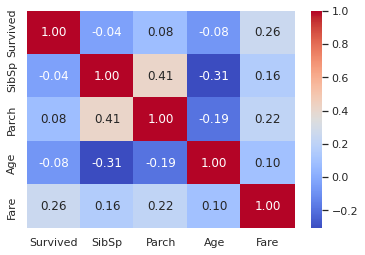

In [12]:
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt = ".2f", cmap="coolwarm")

Fare feature만이 생존 확률과 의미 있는 상관관계를 가지고 있는듯 합니다.  
  
이는 다른 피처들이 쓸모 없다는 의미는 아닙니다. 이러한 피처들의 부분은 생존과 관계가 있을 수 있습니다. 이를 결정 짓기 위해 이러한 피처들의 세부사항들을 탐색해야 합니다.

**SIbSp**

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


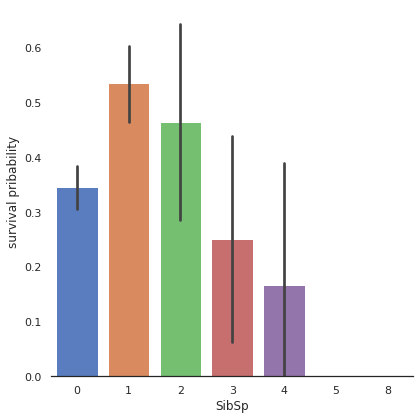

In [13]:
g = sns.factorplot(x = "SibSp", y = "Survived", data=train, kind="bar", size = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival pribability")

많은 형제와 배우자를 둔 승객들은 생존률이 낮은듯 보입니다.  
  
혼자, 혹은 두 명이 서로 함께 있는 (SibSp 1or 2) 승객들은 생존률이 높은 것 같습니다.  
  
이러한 관찰은 꽤 흥미로운데, 우리는 새로운 피처로 고려할 수 있습니다. 이러한 범주를 설명하는

**Parch** 

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


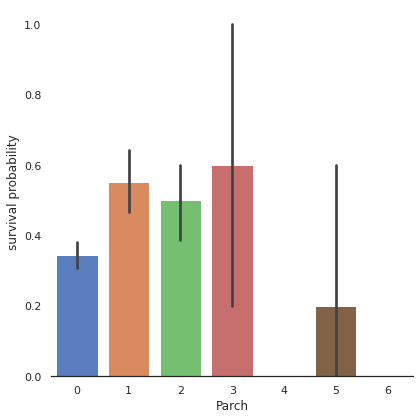

In [14]:
g = sns.factorplot(x = "Parch", y = "Survived", data = train, kind = "bar", size = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

작은 가족들은 생존 확률이 더 높습니다. 싱글(Pacrh 0), 중간(Parch 3,4) 그리고 대가족(Parch 5,6)보다.  
  
부모/아이가 3명인 승객들의 생존에 있어 중요한 표준편차가 있다는 것에 유의하세요.

**Age**

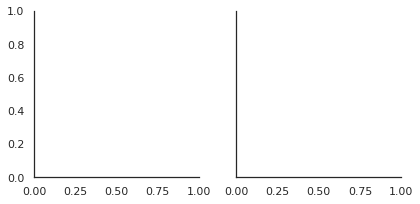

In [15]:
g = sns.FacetGrid(train, col='Survived')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


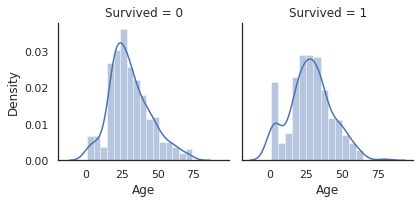

In [16]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

Age 분포는 꼬리를 갖는듯 합니다. 아마 가우시안 분포일 것입니다.  
  
나이 분포들이 생존, 그리고 생존하지 못한 하위 집단에 따라서 같지 않다는 것을 알았습니다. 젊은 승객에 해당하는 봉우리가 있는데, 그들은 살아남았습니다. 또한 60-80 나이의 승객들은 거의 생존하지 못했음을 알 수 있습니다.  
  
따라서, "Age"가 "Survived"와 상관관계를 가지지 않더라도 승객들의 나이 범주에 따라서 더 많거나 적은 생존률이 있다는 것을 확인할 수 있습니다.  
  
매우 젊은 승객들은 더 많은 생존 기회를 얻은듯 합니다.

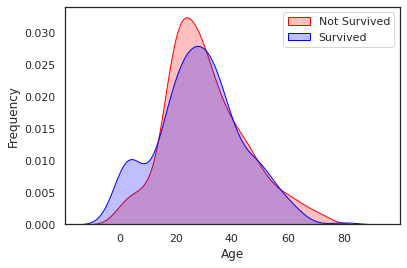

In [17]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax = g, color = "Blue", shade = True)

g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

두 분포를 겹쳐 놓았을 때, 명확하게 볼 수 있습니다. 아기들과 매우 어린 아이들에 관한 봉우리를(0에서 5살 사이)

**Fare**

In [18]:
dataset["Fare"].isnull().sum()

1

In [19]:
# 중앙 값으로 결측치를 채워줍니다.
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

하나의 결측치를 가지고 있기 때문에 중앙 값을 사용해 채우기로 결정했습니다. 이는 예측에 있어 중대한 결과를 가져오지 않을 것입니다.

In [20]:
dataset["Fare"].skew()

4.3695095504693855

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


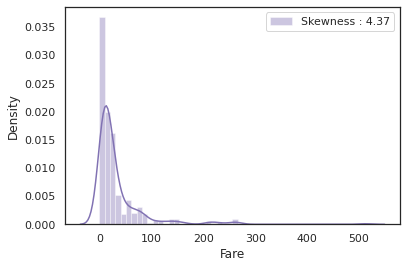

In [21]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best") # best 입력시 자동으로 최적화된 위치에 배치

요금 분포는 매우 편향됐습니다. 이는 모델을 매우 높은 값으로 이끌 수 있습니다. scalsed 된다고 하더라도.  
  
이런 경우, log 함수로 변환해 왜곡을 줄여 주는 것이 좋습니다.

In [22]:
dataset["Fare"] = dataset["Fare"].map(lambda i : np.log(i) if i > 0 else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


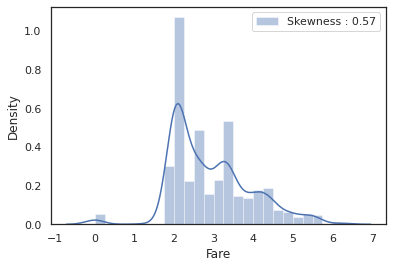

In [23]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

로그 변환 이후 확실히 왜곡 정도가 줄었습니다.

### 3.2 Categorical values

**Sex**

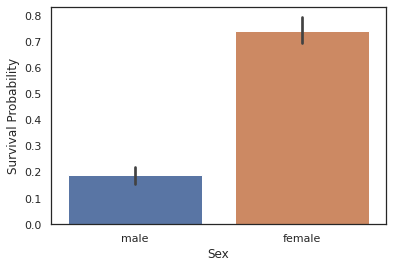

In [24]:
g = sns.barplot(x = "Sex", y = "Survived", data=train)
g = g.set_ylabel("Survival Probability")

In [25]:
train[["Sex", "Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


남자는 생존률에 있어 여성보다 낮은 기회를 가졌다는 것이 매우 확실합니다.  
  
따라서 성별은 아마 생존을 예측하는데 있어 중요한 역할을 할 것입니다.  


**Pclass**

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


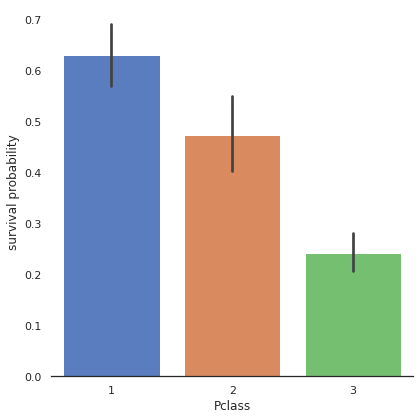

In [26]:
g = sns.factorplot(x = "Pclass", y = "Survived", data=train, kind = "bar", size = 6, palette = "muted")
g.despine(left = True)
g = g.set_ylabels("survival probability")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


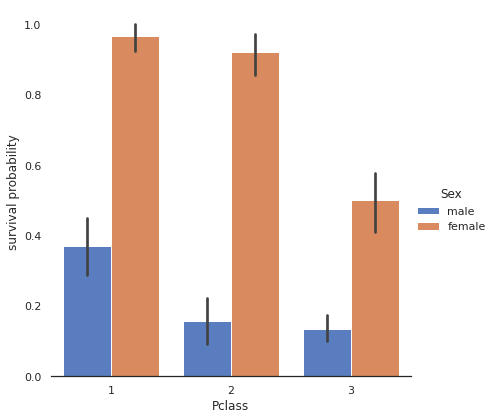

In [27]:
g = sns.factorplot(x = "Pclass", y = "Survived", hue = "Sex", data = train,
                   size = 6, kind = "bar", palette = "muted")
g.despine(left = True)
g = g.set_ylabels("survival probability")

승객 생존률은 3 클래스가 돌링하지 않습니다. 일등석 승객들은 더욱 높은 생존 기회를 얻었습니다. 2, 3등석 승객에 비해  
  
이러한 추세는 남성과 여성 승객들 모두를 볼 때 유효합니다.

**Embarked**

In [28]:
dataset["Embarked"].isnull().sum()

2

In [29]:
# Embarked의 nan 값을 가장 흔한 값인 "S"로 채웁니다.
dataset["Embarked"] = dataset["Embarked"].fillna("S")

두 개의 결측치가 있기 때문에 이를 가장 흔한 값인 Embarked "S"로 채우기로 했습니다.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


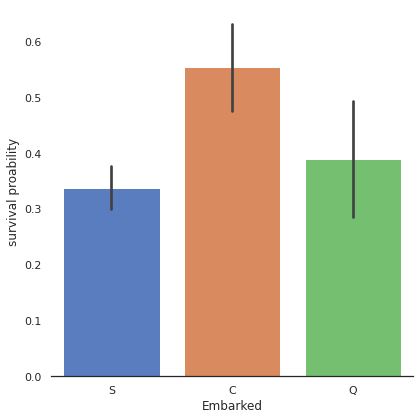

In [30]:
g = sns.factorplot(x = "Embarked", y = "Survived", data = train,
                  size = 6, kind = "bar", palette = "muted")
g.despine(left = True)
g = g.set_ylabels("survival proability")

Cherbourg(C)에서 온 승객들이 더욱 많은 생존 기회를 얻은 듯 합니다.  
  
Queenstown(Q)과 Southampton(S) 보다 Cherbourg(C)의 1등석 승객 비율이 높아서인 것이 가설입니다.  
  
Embarked와 Pclass의 분포를 비교해 봅시다.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


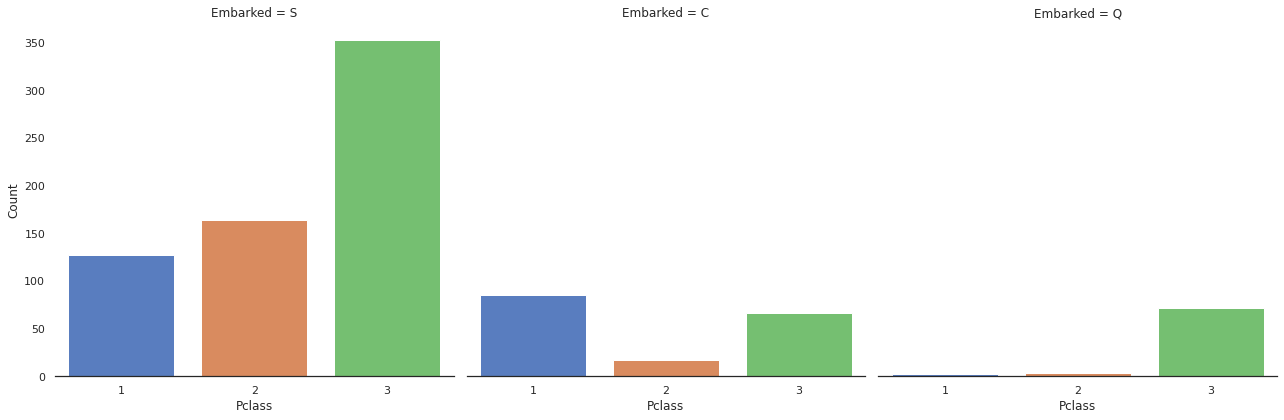

In [31]:
g = sns.factorplot("Pclass", col = "Embarked", data = train,
                   size = 6, kind = "count", palette = "muted")
g.despine(left = True)
g = g.set_ylabels("Count")

역시 세 번째 class는 Southampton(S)와 Quenstown(Q)에서 온 승객들이 가장 흔했습니다. 반면 Cherbourg 승객들은 거의 1등석 이었으며 이 좌석은 가장 높은 생존률을 가졌습니다.  
  
왜 일등석 승객들의 생촌률이 높은지는 설명할 수 없습니다. 가설은 일등석 승객들이 탈출하는데 우선순위를 가졌다는 것입니다. 그들의 영향력을 이용해서

## 4. Filling missing Values

### 4.1 Age

확인했듯 Age 컬럼은 전체 데이터셋에 걸쳐 256개의 결측치를 가지고 있습니다.  
  
더 많은 생존 기회를 갖은 하위 집단이 있기 때문에(예를 들어 아이들), 연령의 측성을 유지해서 결측치를 씌우는 것이 바람직합니다.  
  
이러한 문제를 해결하기 위해 나이와 가장 높은 상관관계를 가지는 피처를 살펴보겠습니다. (Sex, Parch, Pclass, and SibSp).

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

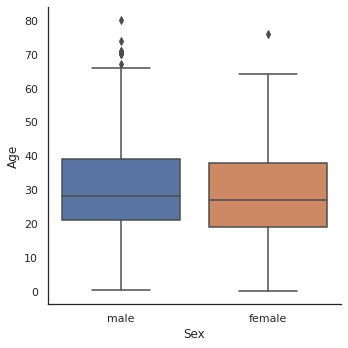

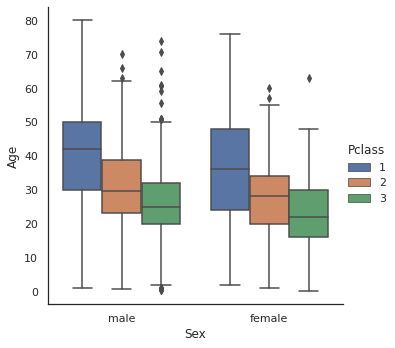

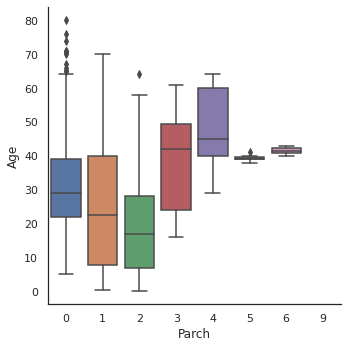

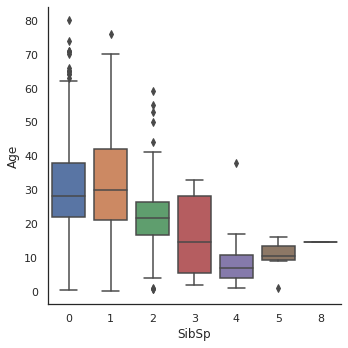

In [32]:
g = sns.factorplot(y = "Age", x = "Sex", data=dataset, kind="box")
g = sns.factorplot(y = "Age", x = "Sex", hue = "Pclass", data = dataset, kind = "box")
g = sns.factorplot(y = "Age", x = "Parch", data = dataset, kind = "box")
g = sns.factorplot(y = "Age", x = "SibSp", data = dataset, kind = "box")

Age 분포는 남성, 여성의 하위 집단이 똑같은 것 같습니다 .따라서 나이를 예측하는데 성별은 정보가 되지 않습니다.  
  
반면 1등성 승객은 2등석 승객등보다 나이가 많으며 또한 2등석 승객은 3등석 승객보다 그렇습니다.  
  
나아가서 승객이 부모나 아이를 많이 가질수록 더 나이가 많으며 형제자매/배우자를 많이 가질수록 어립니다.

In [33]:
# 성별 범주값 전환: 남자=0, 여자=1
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female": 1})

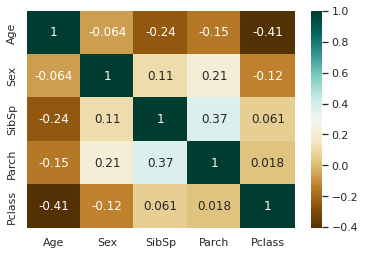

In [34]:
g = sns.heatmap(dataset[["Age", "Sex", "SibSp", "Parch", "Pclass"]].corr(), cmap = "BrBG", annot=True)

상관관계 맵은 확인합니다. Parch를 제외한 factorplot 관측치를. 나이는 성별과 상관관계를 가지고 있지 않지만 Pclass, Parch, SibSp는 음의 상관관계를 가지고 있습니다.  
  
Parch의 함수의 Age 플롯은 Age는 커집니다. 부모/아이의 수가 증가하며. 하지만 전체적인 상관관계는 negative입니다.  
  
따라서 SibSp, Parch, Pclass를 사용하기로 결정했습니다. 나이의 결측치를 채우는데 있어서.  
  
이 전략은 Age를 채우는 것입니다. 비슷한 행의 중간 나이로 Pclass나 Parch, 그리고 SibSp에 따라서

In [35]:
dataset["SibSp"] == dataset.iloc[11]["SibSp"]

0       False
1       False
2        True
3       False
4        True
        ...  
1304     True
1305     True
1306     True
1307     True
1308    False
Name: SibSp, Length: 1309, dtype: bool

In [36]:
# 결측치가 있는 사람과 똑같은 SibSp, Parch, Pclass인 사람의 중위 나이대를 가져옴

index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age:
  age_med = dataset["Age"].median()
  age_pred = dataset["Age"][((dataset["SibSp"] == dataset.iloc[i]["SibSp"])&
                                            (dataset["Parch"] == dataset.iloc[i]["Parch"])&
                                            (dataset["Pclass"] == dataset.iloc[i]["Pclass"]))].median()
  if not np.isnan(age_pred):
    dataset['Age'].iloc[i] = age_pred # 안비었으면 age_pred
  else:
    dataset['Age'].iloc[i] = age_med # 비었으면 age_med

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


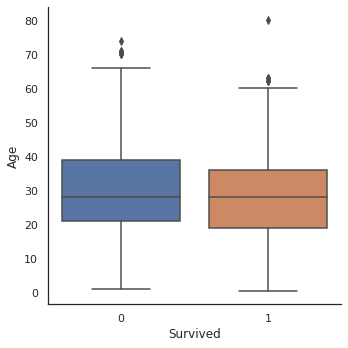

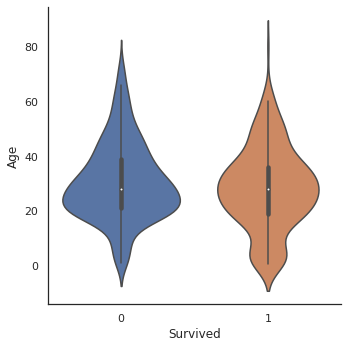

In [37]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

나이의 중위값 간에는 차이가 없습니다. 생존, 그리고 생존하지 못한 하위 집단에서.  
  
하지만 생존한 승객들의 바이올린 플롯에서 매우 젊은 승객들이 높은 생존률을 거진다는 것을 알 수 있습니다.

## 5. Feature engineering

**5.1 Name/Title**

In [38]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Name 피처는 승객의 직함에 대한 정보가 포함돼 있습니다.  
  
어떤 승객들의 구별되는 직함이 탈출에 있어서 선호됐을 수 있습니다. 따라서 모델에 이들을 추가하는 것은 흥미로울 것입니다.

In [39]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [40]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

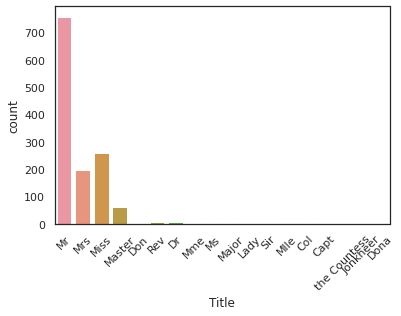

In [41]:
g = sns.countplot(x = "Title", data=dataset)
g = plt.setp(g.get_xticklabels(), rotation = 45)

데이터셋에는 17개의 타이틀이 있으며 그 중 대부분은 매우 희귀합니다. 따라서 4개의 카테고리로 그룹화 하겠습니다.

In [42]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


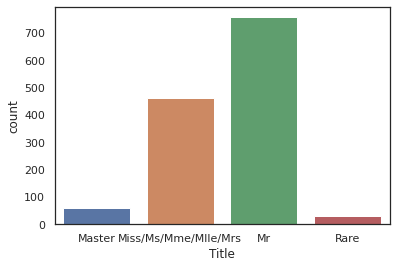

In [43]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


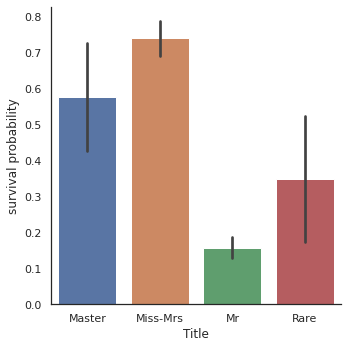

In [44]:
g = sns.factorplot(x = "Title", y = "Survived", data = dataset, kind = "bar")
g = g.set_xticklabels(["Master", "Miss-Mrs", "Mr", "Rare"])
g = g.set_ylabels("survival probability")

"여성과 아이 먼저"  
희귀한 직함을 가진 승객들이 더 많은 생존 기회가 있었다는 점이 흥미롭습니다.

In [45]:
# Name 피처 지우기
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

### 5.2 Family size

탈출에 있어서 대가족은 더욱 어려움을 겪을 것이라고 상상할 수 있습니다. 그들의 자매/형제/부모를 찾으면서. 따라서 "Fsize"(family size)라는 피처를 생성할 것입니다. 이는 SibSp, Parch와 1(승객 포함)의 합입니다.

In [46]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1 # 승객 자신 포함

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


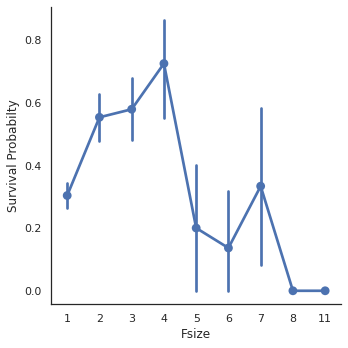

In [47]:
g = sns.factorplot(x = "Fsize", y = "Survived", data = dataset)
g = g.set_ylabels("Survival Probabilty")

가족의 수는 중요한 역할을 수행하는 듯 하며 생존률은 대가족인 때 가장 낮습니다.  
  
추가적으로, 가족 사이즈를 4개의 카테고리로 나누겠습니다.

In [48]:
dataset['Single'] = dataset["Fsize"].map(lambda s: 1 if s == 1 else 0)
dataset["SmallF"] = dataset["Fsize"].map(lambda s: 1 if s == 2 else 0)
dataset["MedF"] = dataset["Fsize"].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset["LargeF"] = dataset["Fsize"].map(lambda s: 1 if s >= 5 else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

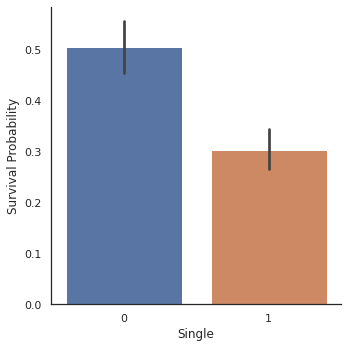

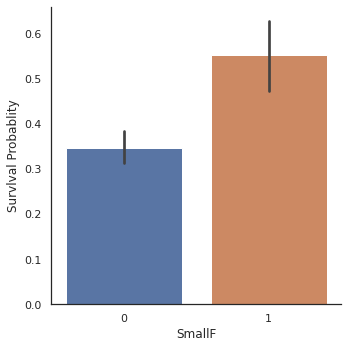

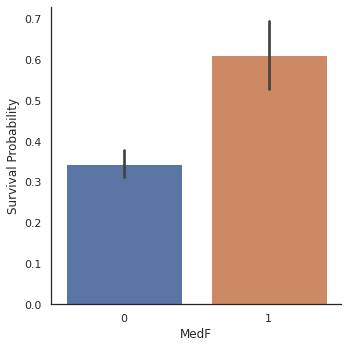

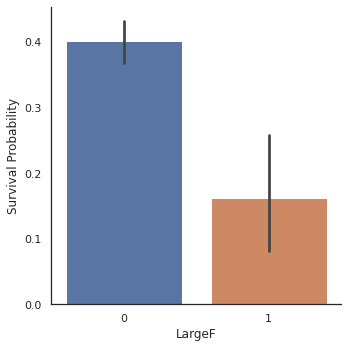

In [49]:
g = sns.factorplot(x = "Single", y = "Survived", data = dataset, kind = "bar")
g = g.set_ylabels("Survival Probability")

g = sns.factorplot(x = "SmallF", y = "Survived", data = dataset, kind = "bar")
g = g.set_ylabels("Survlval Probablity")

g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

가족 수 범주의 factorplot들은 작고 중간 정도의 가족들을 보여줍니다. 이들은 혼자인 승객이나 대가족보다 더욱 많은 생존 기회를 얻었습니다.

In [50]:
dataset[["Title", "Embarked"]]

,Title,Embarked
0,2,S
1,1,C
2,1,S
3,1,S
4,2,S
...,...,...
1304,2,S
1305,3,C
1306,2,S
1307,2,S


In [51]:
# Title과 Embarked를 지표 값으로 변환
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix = "Em")

In [52]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,2,0,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,2,0,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,1,1,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,2,0,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,1,1,0,0,0,0,0,1,0,0,0,1


22개의 피처가 있습니다.

### 5.3 Cabin

In [53]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [54]:
dataset["Cabin"].describe()

count             295
unique            186
top       C23 C25 C27
freq                6
Name: Cabin, dtype: object

In [55]:
dataset["Cabin"].isnull().sum()

1014

Cabin 피처의 열은 295개의 값을 가지고 있으며 1014개의 결측치가 있습니다.  
  
선실이 없는 승객들은 결측치가 표시된다고 가정했습니다. 선실 번호 대신에.

In [56]:
dataset["Cabin"].notnull()

0       False
1        True
2       False
3        True
4       False
        ...  
1304    False
1305     True
1306    False
1307    False
1308    False
Name: Cabin, Length: 1309, dtype: bool

In [57]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [58]:
pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

0       X
1       C
2       X
3       C
4       X
       ..
1304    X
1305    C
1306    X
1307    X
1308    X
Length: 1309, dtype: object

In [59]:
# 선실의 타입으로 선실 번호 대체하기 만약 결측치가 있다면 'X'로 대체
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

선실의 첫 번째 글자는 선반을 나타냅니다.  해당 정보만을 남겨 두기로 결정했습니다. 왜냐하면 이는 가능성을 나타냅니다. 타이타닉에서 승객의 위치의

In [60]:
 a = dataset["Cabin"].unique()
 a.sort()
a = list(a)
a

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


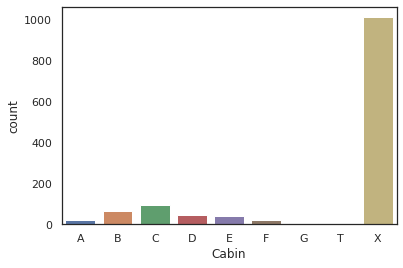

In [61]:
g = sns.countplot(dataset["Cabin"], order = a)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


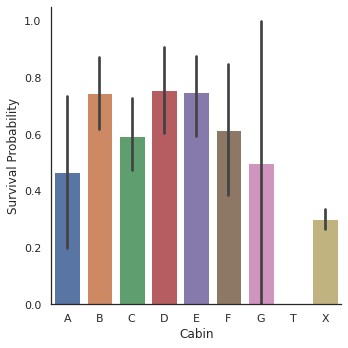

In [62]:
g = sns.factorplot(y = "Survived", x = "Cabin", data = dataset,
                          kind = "bar", order = a)
g = g.set_ylabels("Survival Probability")

선실을 가지고 있는 승객의 수가 적었기 때문에 생존률은 중요한 표준 편차를 가지며 우리는 서로 다른 데스크의 승객의 생존률을 구할 수 없습니다.  
  
하지만 선실을 가지고 있는 승객들이 일반적으로 더욱 많은 생존률을 가진다는 것을 확인할 수 있습니다. 선실을 가지지 않은 승객보다.(X)  
  
이는 특히 선실 B, C, D, E, F에서 그렇습니다.

In [63]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"], prefix = "Cabin")

### 5.4 Ticket

In [64]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

티겟 공유를 의미할 수 있습니다. 같은 앞글자가 선실이 함께 위치하도록 예약됐을 수 있다는 것을. 그러므로 이는 이끌어낼 수 있습니다. 실제로 선실의 위치가 배의 안쪽에 있다고.  
  
같은 앞글자를 가진 티켓은 어쩌면 비슷한 class나 생존률을 가질 수 있습니다.  
  
따라서 Ticket 피처 열을 티켓의 앞글자로 대체할 것입니다. 티켓의 앞글자는 어쩌면 더욱 유용할 수 있습니다.

In [65]:
"STON/O2. 3101282".replace(".", "").replace("/", "").strip().split(' ')[0]

'STONO2'

In [66]:
Ticket = []
for i in list(dataset.Ticket):
  if not i.isdigit():
    Ticket.append(i.replace(".", "").replace("/", "").strip().split(' ')[0])
  else:
    Ticket.append("X")

dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [67]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix = "T")

In [68]:
# Pclass에 대해서 범주 값을 생성합니다.
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"], prefix = "Pc")

In [69]:
# 쓸모 없는 값을 제거합니다.
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [70]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,T_A,T_A4,T_A5,T_AQ3,T_AQ4,T_AS,T_C,T_CA,T_CASOTON,T_FC,T_FCC,T_Fa,T_LINE,T_LP,T_PC,T_PP,T_PPP,T_SC,T_SCA3,T_SCA4,T_SCAH,T_SCOW,T_SCPARIS,T_SCParis,T_SOC,T_SOP,T_SOPP,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


## 6.MODELING

In [71]:
# drop에서 labels 파라미터: 인덱스나 컬럼 레이블을 드랍

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels = ["Survived"], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [72]:
# train feature랑 label을 분리합니다.

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"], axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### 6.1 Simple modeling

**6.1.1 Cross Validate models**  
10개의 인기 있는 분류기를 비교하고 이들 각각에 대해서 평균적인 정확도를 평가할 것입니다. stratified kfold cross validation 절차를 이용해서.
* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perception (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis

In [73]:
kfold = StratifiedKFold(n_splits = 10)

In [74]:
# 서로 다른 알고리즘을 검정하는 모델링 단계

random_state = 2
classifiers = []
classifiers.append(SVC(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [75]:
cv_results = []
for classifier in classifiers:
  cv_results.append(cross_val_score(classifier, X_train, y = Y_train,
                                                    scoring="accuracy", cv=kfold, n_jobs=4)) # n_jobs = 병렬로 실행할 작업 수

In [76]:
cv_means = []
cv_std = []
for cv_result in cv_results:
  cv_means.append(cv_result.mean())
  cv_std.append(cv_result.std())

In [77]:
cv_res = pd.DataFrame({"CrossValMeans": cv_means, "CrossValerrors": cv_std,
                                    "Algorithm":["SVC", "DecisionTree", "AdaBoost",
                                                  "RandomForest", "ExtraTrees", "GradientBoosting",
                                                 "MultipleLayerPerceptron", "KNeighbors", "LogisticRegression",
                                                 "LinearDiscriminantAnalysis"]})

In [78]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.728439,0.037824,SVC
1,0.799164,0.033018,DecisionTree
2,0.798052,0.048830,AdaBoost
3,0.810387,0.047466,RandomForest
4,0.807041,0.047675,ExtraTrees
5,0.832784,0.038357,GradientBoosting
6,0.823845,0.045535,MultipleLayerPerceptron
7,0.798027,0.042947,KNeighbors
8,0.826055,0.029720,LogisticRegression
9,0.827179,0.037236,LinearDiscriminantAnalysis


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


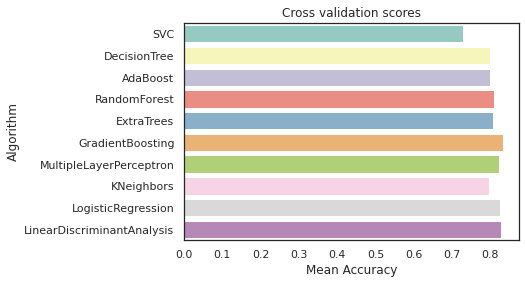

In [79]:
# **{'xerr' :cv_std} 이랑 비교

g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res, palette="Set3",
                orient="h") # orient: Orientation of the plot
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


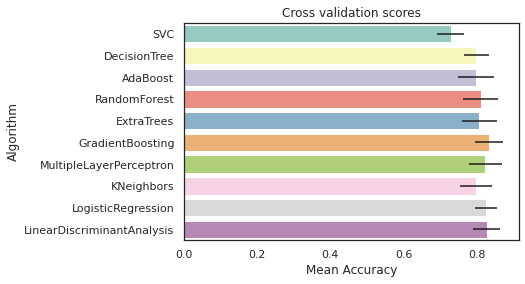

In [80]:
g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res, palette="Set3",
                orient="h", **{'xerr' :cv_std}) # orient: Orientation of the plot
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

앙상블 모델링으로 SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting 분류기를 사용하겠습니다.

**6.1.2 Hyperparameter tunning for best models**  
AdaBoost, ExtraTrees, RandomForest, GradientVoosting, SVC 분류기에 대해 grid search 최적화를 수행하겠습니다.  
  
"n_jobs" 파라미터를 4로 설정했습니다. cpu를 4개 가지고 있어서. 계산 시간이 확실히 줄었습니다.  
  
저자의 경우 15분이 걸렸습니다.

In [81]:
# META MODELING WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

AdaBoostClassifier는 일반적으로 base 트리로 DecisionTreeClassifier를 상속받는다.  
  
여기서 'n_estimators'(약한 학습기의 수)와 'learning_rate'는 trade-off 관계에 있기에 이 두 파라미터를 잘 조정하는 것이 AdaBoost 하이퍼 파라미터 튜닝의 핵심이다.  
  
**Reference**  
https://sevillabk.github.io/Boosting/

In [82]:
# Adaboost

DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion": ["gini", "entropy"],
                              "base_estimator__splitter": ["best", "random"],
                              "algorithm": ["SAMME", "SAMME.R"],
                              "n_estimators": [1, 2],
                              "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}
gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv=kfold,
                                      scoring = "accuracy", n_jobs = -1, verbose = 1)

gsadaDTC.fit(X_train, Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [83]:
gsadaDTC.best_score_

0.8171535580524344

Extratreesclassifier는 base 트리로 Extratreeclassifier를 사용한다.  
  
Extratreeclassifier는 DecisionTreeClassifier를 상속한 것이며 여기에서 파라미터만 다르다.
* splitter = 'random'
* max_features = 'auto'
일반적으로 Extratreesclassifier는 Randomforest보다 폭 넓은 시각으로 특성을 평가하며 특성의 중요도 또한 전반적으로 높게 평가하는 경향이 있다.  
  
**Reference**  
https://tensorflow.blog/2017/11/30/%EB%8D%94%EC%9A%B1-%EB%9E%9C%EB%8D%A4%ED%95%9C-%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8-%EC%9D%B5%EC%8A%A4%ED%8A%B8%EB%A6%BC-%EB%9E%9C%EB%8D%A4-%ED%8A%B8%EB%A6%ACextratreesclassifier/

In [84]:
# ExtraTrees

ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
                 "max_features": [1, 3, 10],
                 "min_samples_split": [2, 3, 10],
                 "min_samples_leaf": [1, 3, 10],
                 "bootstrap": [False],
                 "n_estimators": [100, 300],
                 "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold,
                      scoring="accuracy", n_jobs=-1, verbose=1)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.836167290886392

In [85]:
# RFC Parameters tunning

RFC = RandomForestClassifier()

# Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
                          "max_features": [1, 3, 10],
                          "min_samples_split": [2, 3, 10],
                          "min_samples_leaf": [1, 3, 10],
                          "bootstrap": [False],
                          "n_estimators": [100, 300],
                          "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv = kfold,
                     scoring = "accuracy", n_jobs = 4, verbose = 1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

# Bast score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8384019975031212

In [86]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
                            'n_estimators' : [100, 200, 300],
                            'learning_rate' : [0.1, 0.05, 0.01],
                            'max_depth' : [4, 8],
                            'min_samples_leaf' : [100, 150],
                            'max_features' : [0.3, 0.1]
                            }

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv = kfold, scoring = "accuracy",
                                    n_jobs = 4, verbose = 1)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8316729088639201

In [87]:
# SVC classifier

SVMC = SVC(probability = True)
svc_param_grid = {'kernel' : ['rbf'],
                            'gamma' : [0.001, 0.01, 0.1, 1],
                            'C' : [1, 10, 50, 100, 200, 300, 1000]}
            
gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv = kfold, scoring = "accuracy",
                                  n_jobs = -1, verbose = 1)

gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8350187265917602

**6.1.3 Plot learning curves**  
러닝 커브는 트레이닝 셋에 대한 오버피팅 이펙트를 확인할 수 있는 좋은 방법입니다. 또한 트레이닝 사이즈가 정확도에 미치는 영향도 확인할 수 있습니다.

In [88]:
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [89]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                                  n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
  """ training, test에 대한 간단한 플롯을 생성합니다. """
  plt.figure()
  plt.title(title)

  if ylim is not None:
    plt.ylim(*ylim)
  
  plt.xlabel("Training examples")
  plt.ylabel("Score")
  train_sizes, train_scores, test_scores = learning_curve(
      estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis = 1)
  train_scores_std = np.std(train_scores, axis = 1)
  test_scores_mean = np.mean(test_scores, axis = 1)
  test_scores_std = np.std(test_scores, axis = 1)
  plt.grid()

  plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std, alpha = 0.1, color="r")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std, alpha = 0.1, color="g")
  
  plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
  plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

  plt.legend(loc="best")
  return plt

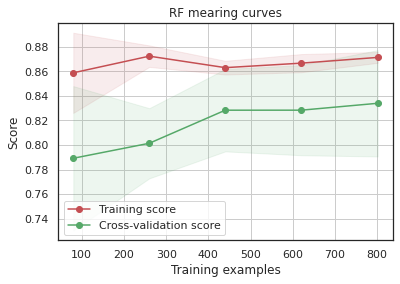

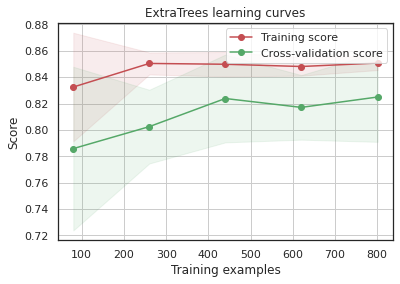

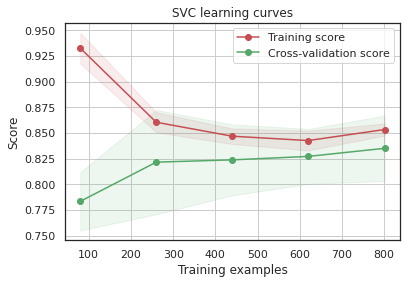

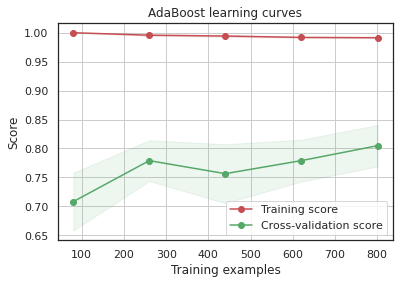

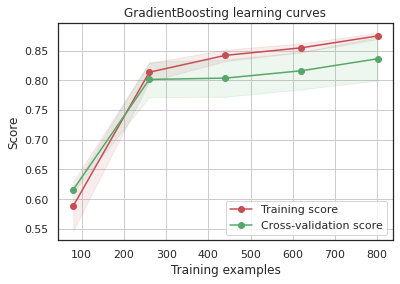

In [90]:
g = plot_learning_curve(gsRFC.best_estimator_, "RF mearing curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, "ExtraTrees learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, "SVC learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, "AdaBoost learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, "GradientBoosting learning curves", X_train, Y_train, cv=kfold)

그라디언트부스팅, 에이다부스트 분류기는 트레이닝 셋에 대해서 과적합되는 경향이 있습니다. 증가하는 크로스 밸리데이션 커브에 의하면 그라디언트부스팅과 에이다부스트는 트레이닝 예시가 더 있다면 더욱 좋은 결과를 불러올 수 있습니다.  
  
SVC와 ExtraTrees 분류기는 예측에 있어서 더욱 일반화를 잘 시키는듯 합니다. training, cross-validation 커브가 서로 가깝기 때문입니다.

**6.1.4 Feature importances of tree based classifiers**  
승객의 생존률에 대한 예측에 있어 가장 높은 정보 피처를 확인하기 위해서 피처의 중요도를 나타냈습니다. 4개의 tree 기반 분류기의

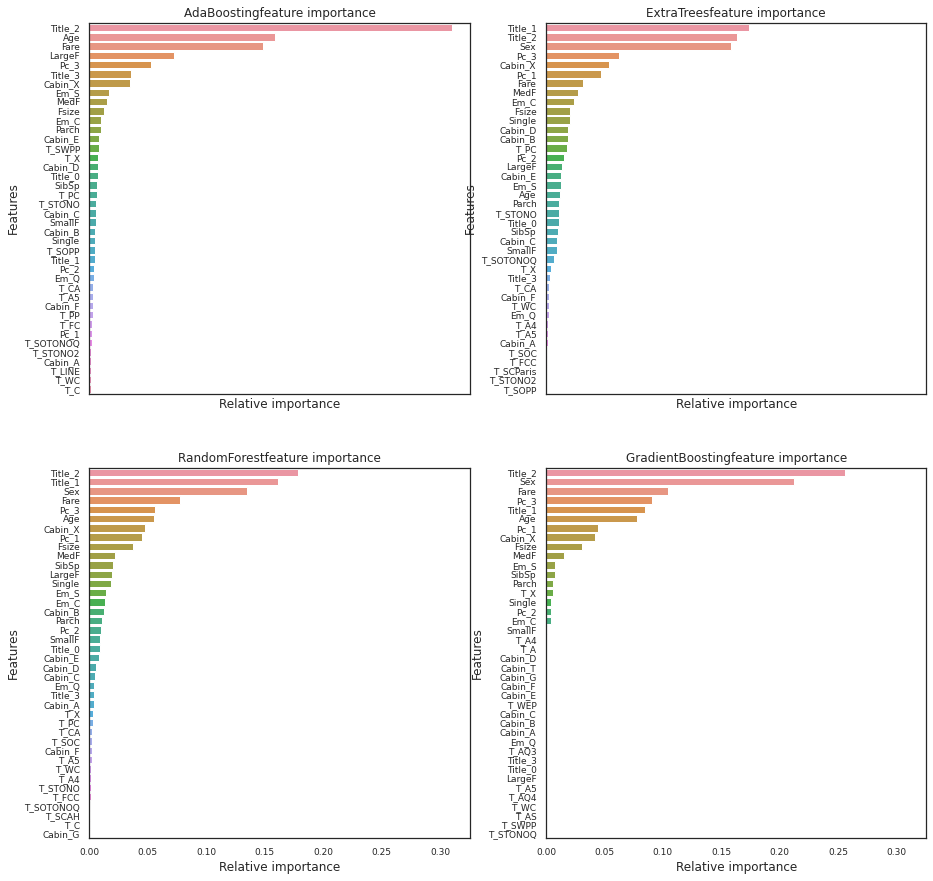

In [91]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15, 15))

names_classifiers = [("AdaBoosting", ada_best), ("ExtraTrees", ExtC_best), ("RandomForest", RFC_best),
                              ("GradientBoosting", GBC_best)]

nclassifier = 0
for row in range(nrows):
  for col in range(ncols):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    g = sns.barplot(y=X_train.columns[indices][:40], x=classifier.feature_importances_[indices][:40],
                            orient='h', ax=axes[row][col])
    g.set_xlabel("Relative importance", fontsize=12)
    g.set_ylabel("Features", fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + "feature importance")
    nclassifier += 1

4개의 tree 기반 분류기에 대한 피처 중요도를 그렸습니다. (Adaboost, ExtraTrees, RandomfForest, GradiendBoosting).  
  
네 개의 분류기는 상대적인 중요도에 따라서 다른 주요 특징을 가지고 있다는 점에 주목해야 합니다. 이는 그들의 예측이 같은 특징에 기반한다는 것을 의미합니다. 그럼에도 불구하고, 그들은 분류에 있어 몇 가지 공통되고 흔한 특징을 공유합니다. 예를 들어 'Fare', 'Title_2', 'Age', 'Sex'입니다.  
  
Title_2는 Mrs/Mlle/Mme/Miss/Ms 카테고리를 나타내는데 이는 성별과 매우 높은 상관관계를 가지고 있습니다.  
  
따라서 다음과 같이 말할 수 있을 것입니다.  
* Pc_1, Pc_2, Pc_3 그리고 Fare는 승객의 일반적인 사회적 위치를 언급합니다.
* Sex and Title_2 (Mrs/Mlle/Mme/Miss/Ms) and Title_3 (Mr)은 성별을 의미합니다.
* Age 그리고 Title_1 (Master)은 승객의 나이를 의미합니다.
* Fsize, LargeF, MedF, Single은 승객의 가족 크기를 의미합니다.  
  
**이러한 4개 분류기의 피처 중요도에 의하면 생존의 예측은 나이, 성별, 그리고 가족 크기, 승객의 사회적 위치와 연관돼 있습니다. 보트의 위치보다.**

In [91]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

5개의 분류기의 예측은 꽤 비슷해 보입니다. Adaboost가 나머지 다른 분류기와 비교될 때를 제외하면.  
  
5개의 분류기는 많거나 적은 같은 예측을 주는 반면 다른 점도 있습니다. 5개 분류기의 예측 사이의 이러한 차이는  앙상블 vote를 고려하기에 충분합니다.

### 6.2 Ensemble modeling

**6.2.1 Combining models**

보팅 분류기를 엮어 5개 분류기의 예측을 결합할 것입니다.  

In [92]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

### Prediction

**6.3.1 Predict and Submit results**

In [93]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)